# Bio-Feedback Pipeline

## Run Code to train model with old data before experiment (only do once)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Define the Kalman Filter Function
def kalman(measurement_list, process_noise, variance, pipeline, files=None):
    """Kalman filter
    Args:
        measurement_list ([float]): A time-ordered series of environmental estimates
        process_noise (float): Approximate process noise for the estimation process.
        variance (float or [float]): Either a single value (for static variance)
            or a list of values (for dynamic variance)
    Returns:
        [float]: Kalman filtered estimate buffer
    """
    if len(measurement_list) <= 1:
        return measurement_list
    dyn_variance = type(variance) is not float
    estimate_buffer = []
    if 'Speed' in pipeline:
        prior_estimate = 0.6
        prior_variance = 0.2 if dyn_variance else variance
    elif 'Slope' in pipeline:
        prior_estimate = 10
        prior_variance = 1 if dyn_variance else variance
    elif 'Height' in pipeline:
        prior_estimate = 15
        prior_variance = 1.2 if dyn_variance else variance

    for i in range(len(measurement_list)):
        if files is None or files[i] == files[i - 1]:
            # Zn Measurements
            single_measurement = measurement_list[i]
            #single_variance = abs(variance[i]) if dyn_variance else variance
            single_variance = variance
            # Update
            k_gain = prior_variance / (prior_variance + single_variance)
            if estimate_buffer:
                estimate = estimate_buffer[i - 1] + k_gain * (single_measurement - estimate_buffer[i - 1])
            else:
                estimate = prior_estimate + k_gain * (single_measurement - prior_estimate)
            estimate_buffer.append(estimate)

            # Update Variance
            prior_variance = (1 - k_gain) * prior_variance + process_noise
        else:
            estimate_buffer.append(measurement_list[i])
            #prior_variance = abs(variance[i]) if dyn_variance else variance
            prior_variance = variance
    return np.array(estimate_buffer)





feature_table_names = []
peak_values = []; #This initializes the peak torque values matrix for later use

# Desired channels to train with 
#col_names = ['right_FP_x', 'right_FP_y', 'right_FP_z', 
#          'left_FP_x', 'left_FP_y', 'left_FP_z', 
#          'shank_acc_x', 'shank_acc_y', 'shank_acc_z', 'shank_gyro_x', 'shank_gyro_y', 'shank_gyro_z' ,
#          'foot_acc_x', 'foot_acc_y', 'foot_acc_z', 'foot_gyro_x', 'foot_gyro_y', 'foot_gyro_z', 
#          'thigh_acc_x', 'thigh_acc_y', 'thigh_acc_z', 'thigh_gyro_x', 'thigh_gyro_y', 'thigh_gyro_z', 
#          'torso_acc_x', 'torso_acc_y', 'torso_acc_z', 'torso_gyro_x', 'torso_gyro_y', 'torso_gyro_z',]
col_names = ['shank_acc_x', 'shank_acc_y', 'shank_acc_z', 'shank_gyro_x', 'shank_gyro_y', 'shank_gyro_z' ,
           'foot_acc_x', 'foot_acc_y', 'foot_acc_z', 'foot_gyro_x', 'foot_gyro_y', 'foot_gyro_z', 
           'thigh_acc_x', 'thigh_acc_y', 'thigh_acc_z', 'thigh_gyro_x', 'thigh_gyro_y', 'thigh_gyro_z', 
          'torso_acc_x', 'torso_acc_y', 'torso_acc_z', 'torso_gyro_x', 'torso_gyro_y', 'torso_gyro_z'
          ]
col_feat = ['min_','max_', 'mean_', 'std_', 'end_']


#feature_table_length = col_names*col_feat

for i in range(len(col_names)):
    for j in range(len(col_feat)):
    
        
        feature_table_names.append(col_feat[j]+col_names[i])

        

        
#Create labels for ground truth labels
ground_truth_names = ['hip_torque','knee_torque', 'L5_S1_flex_torque']




from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# subjects used for training the model
subject_num = ['04', '05', '06', '07', '09','10','15']
lift_type = 'KW' #Lift type
degree = 180 #Degree of lift
lift_side = 'R' #Side the lift starts on
side = lift_side #These two variables are the same thing

#IF TRAINING ON ALL THE SUBJECT, SET test_sub T0 '100'
c = 0 #Index of the test subject in subarray
test_sub = subject_num[c]
#test_sub = '100'

data_train = pd.DataFrame()

start_i = 0


# add all data across subjects and trial to data_train
for j in range(start_i,len(subject_num)):
    #Does not add test_sub to training set if test_sub exists
    if subject_num[j] == test_sub:
                message = "--- Subject "+str(subject_num[j])+" is test Trial --- "
                print('---------------')
                print(message)
                print('---------------')
    else:
        for i in range(1,8):

                message = "--- Adding Subject "+ str(subject_num[j]) + " Trial " +str(i)+"  to the training data ---"
                print(message)
                if degree == 0:
                    file = "D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_"+str(subject_num[j])+"_L_"+str(degree)+"_"+lift_type+"_0"+str(i)+".csv"
                else:
                    file = "D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_"+str(subject_num[j])+"_L_"+str(degree)+"_"+lift_side+"_"+lift_type+"_0"+str(i)+".csv"
                print(file)
                data = pd.read_csv(file)
                print("Data Row: "+str(data.shape[0]))
                data_train = pd.concat([data_train,data],ignore_index=True)





print('Train Trials:')
print(data_train.info())

#Seperate the training set features and labels
x_train = data_train[feature_table_names]
y_train = data_train[ground_truth_names]

print('Train Trials:')
print(x_train.info())

#Scale the data
sc=StandardScaler()

scaler = sc.fit(x_train)
x_train_scaled = scaler.transform(x_train)

# Create Models


model_L5S1 = XGBRegressor()

kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
GT_lumbar_torque = y_train.L5_S1_flex_torque
data_convolved = np.convolve(GT_lumbar_torque, kernel, mode='same')

model_L5S1.fit(x_train_scaled,data_convolved)





    




---------------
--- Subject 04 is test Trial --- 
---------------
--- Adding Subject 05 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_01.csv
Data Row: 136
--- Adding Subject 05 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_02.csv
Data Row: 139
--- Adding Subject 05 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_03.csv
Data Row: 136
--- Adding Subject 05 Trial 4  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_04.csv
Data Row: 135
--- Adding Subject 05 Trial 5  to the training data ---
D:/Dro

--- Adding Subject 15 Trial 4  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_180_R_KW_04.csv
Data Row: 140
--- Adding Subject 15 Trial 5  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_180_R_KW_05.csv
Data Row: 137
--- Adding Subject 15 Trial 6  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_180_R_KW_06.csv
Data Row: 142
--- Adding Subject 15 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_180_R_KW_07.csv
Data Row: 137
Train Trials:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5980 entries, 0 to 5979
Columns: 168 entries, min_right_FP_x to 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Start matlab engine (only run this once) 

In [2]:
import matlab.engine

eng = matlab.engine.start_matlab()

## The next part of the Pipeline Needs to be Run after Trial

### 1. It reads the c3d file that vicon creates and then build the feature tables
### 2. It predicts the lumbar bio-torque from the model creates above

### The next block is used to determine the file that needs to be read. It should be updated after each trial so that it reads the most recent data

In [15]:
subject = '04'
trial = '04'

#Should be the same conidtons as the trained values
#degree = 90
#side = 'R'
#lift_type = 'KW'



weight_kg = 66.9582 #Sub 4 mass
#weight_kg = 90.9117 #sub 5 mass
#weight_kg = 60.2836 #Sub 6 mass
#weight_kg = 86.882 #sub 7 mass
#weight_kg = 89.48 #Sub 9 mass
#weight_kg = 66.8298 #sub 10 mass
#weight_kg = 85.494 #Sub 15 mass


### The next block makes a prediction of the lumbar bio-torque

In [16]:

if degree == 0:
    c3dFilePath = "D:\\Dropbox (Gatech)\\DOE_Exos\\Experiments\\DOE Biomechanics\\DOE_Biomech_"+subject+"_PROCESSED\\New Session\\DOE_Biomech_"+subject+"_L_"+str(degree)+"_"+lift_type+"_"+trial+"_filled.c3d"
else:
    c3dFilePath = "D:\\Dropbox (Gatech)\\DOE_Exos\\Experiments\\DOE Biomechanics\\DOE_Biomech_"+subject+"_PROCESSED\\New Session\\DOE_Biomech_"+subject+"_L_"+str(degree)+"_"+side+"_"+lift_type+"_"+trial+"_filled.c3d"
    
print(c3dFilePath)
results_features, labels_features = eng.generate_feature_tables(c3dFilePath, degree)
df_features = pd.DataFrame(results_features,columns=labels_features)

x_test = df_features[feature_table_names]
x_test_scaled = scaler.transform(x_test)


y_pred_back =  model_L5S1.predict(x_test_scaled)



process_noise = 0.1
variance = np.var(y_pred_back)
#print(variance)
pipeline = 'Speed'

ML_pred_filtered = kalman(y_pred_back, process_noise, variance,pipeline)


D:\Dropbox (Gatech)\DOE_Exos\Experiments\DOE Biomechanics\DOE_Biomech_04_PROCESSED\New Session\DOE_Biomech_04_L_180_R_KW_04_filled.c3d


### Have matlab plot out the predicted peak torque of the lift

In [17]:
torque_data = ML_pred_filtered*weight_kg


peak_torque= max(torque_data)
peak_values = np.append(peak_values,peak_torque)
print(peak_values)
finished = eng.plot_torque_info(torque_data.tolist(), peak_values.tolist())

[145.18804121 140.52802675 149.33734422 144.09806883]


### Clear the peak values so that it does not keep plotting old peak data

In [ ]:
print(peak_values)
peak_values = np.array([]);

### The next block is used to plot the prediction. This is making a prediction of bio-torque that we already know so it is plotted vs the ground truth (this will not be possible in the actual experiments because we will not know ground truth

D:\Dropbox (GaTech)\DOE_Exos\Experiments\Analysis\UPDATED_BIOMECH_AUTOMATED_ANALYSIS\Results\DOE_Biomech_04\Model_LFB\ID\DOE_Biomech_04_L_180_R_KW_04_ID.sto


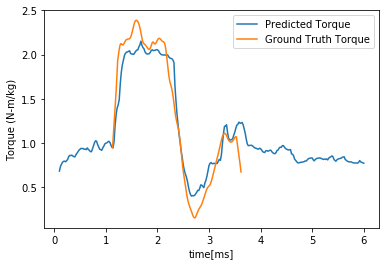

In [18]:

window_increment = 0.02
start_time = 0.1

time = np.arange(start_time, len(ML_pred_filtered)*window_increment+start_time, window_increment)
plt.plot(time, ML_pred_filtered, label='Predicted Torque')

#read ground truth torques
if degree == 0:
    torques_file = 'D:\\Dropbox (GaTech)\\DOE_Exos\\Experiments\\Analysis\\UPDATED_BIOMECH_AUTOMATED_ANALYSIS\\Results\\DOE_Biomech_'+subject+'\\Model_LFB\\ID\\DOE_Biomech_'+subject+'_L_'+str(degree)+'_'+lift_type+'_'+trial+'_ID.sto'
else:
    torques_file = 'D:\\Dropbox (GaTech)\\DOE_Exos\\Experiments\\Analysis\\UPDATED_BIOMECH_AUTOMATED_ANALYSIS\\Results\\DOE_Biomech_'+subject+'\\Model_LFB\\ID\\DOE_Biomech_'+subject+'_L_'+str(degree)+'_'+side+'_'+lift_type+'_'+trial+'_ID.sto'
    
print(torques_file)   
data,column_names = eng.readSTO(torques_file)
df_torque = pd.DataFrame(data, columns = column_names)
#print(df_torque['time'])
#print(df_torque['L5_S1_Flex_Ext_moment'])
#weight_kg = 66.9582 #Sub 4 mass
#weight_kg = 90.9117 #sub 5 mass
#weight_kg = 60.2836 #Sub 6 mass
#weight_kg = 86.882 #sub 7 mass
#weight_kg = 89.48 #Sub 9 mass
#weight_kg = 66.8298 #sub 10 mass
#weight_kg = 85.494 #Sub 15 mass


kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
GT_lumbar_torque = df_torque['L5_S1_Flex_Ext_moment']
data_convolved = np.convolve(GT_lumbar_torque, kernel, mode='same')


plt.plot(df_torque['time'], data_convolved/weight_kg, label = 'Ground Truth Torque')

plt.legend()
plt.xlabel('time[ms]')
plt.ylabel('Torque (N-m/kg)')
plt.show()



## This cell stops the Matlab Engine (Run this at the end of each experiment)

In [ ]:
# Stop Matlab Engine
eng.quit()